In [1]:
# general imports needed by functions
import errno    
import os

# import python scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import needed keras objects into current namespace
from keras import layers
from keras import models
from keras import optimizers
import keras


Using TensorFlow backend.


In [2]:
# set plotting visual style and parameters for all plotted figures
%matplotlib inline
sns.set_style('darkgrid') # use seaborn style to improve visual presentation
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (12.0 , 8.0)

In [3]:
# check which devices tensorflow has recognized and is using
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14922388522385242806
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3564568576
locality {
  bus_id: 1
}
incarnation: 1618791550412076900
physical_device_desc: "device: 0, name: Quadro M2200, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


# 8 Generative deep learning

Look at data generation of sequence data (for text) and images (DeepDream), variational autoencoders and
generative adversarial networks.

## 8.1 Text generation with LSTM

Using neural network to generate sequence data.

### 8.1.1 A brief history of generative recurrent networks

### 8.1.2 How do you generate sequence data?

The universal way to generate sequence data is to train a network (usually RNN or convnet) to predict
the next token or next few tokens in a sequence, using the previous (N) tokens as input.

Once you have such a trained sequence predictor, you can *sample* from it (generate new sequences).
You feet it an initial seed string of text (or prompt, also called *conditioning data*), ask it to
generate the next character (or token in your sequence), add the generated output back to the
input data, and repat the process many times.  This loop allows you to generate sequences
of arbitrary length that reflect the structure of the data on which the model was trained.


### 8.1.3 The importance of the sampling strategy

*Greedy sampling* consisting of always choosing the most likely next character.  But this results in
repetitive, predictable strings being generated that don't look like coherent sequences.

*Stochastic sampling* is sampling from the probability distribution for the next character.  If *e*
has a 0.3 probability of being the next token, you choose it 30% of the time.

But a strict stochastic sampling approach doesn't allow you to control the amount of randomness.
We might want more randomness to increase the perceived "surpriseness" of the sequences.  In order
to control the amount of stochasticity in the sampling process, we'll introduce a parameter called
the *softmax temperature* that characterizes the entropy of the probability
distribution: it characterizes how surprising or predictable the choice of the next character
will be.  Given a *temperature* value, a new probability distribution is computed form the original,
by reweighting it in the following way.

In [4]:
def reweight_distribution(original_distribution, temperature=0.5):
    """Original_distribution is a 1D Numpy array of probability
    values that must sum to 1.  Temperature is a factor quantifying
    the entropy of the output distribution.
    """
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    
    # returns reweighted version of the original distribution.
    # the sum of the distribtuion my no longer be 1, so divide it by
    # sum to renormalize to a probability distribution
    return distribution / np.sum(distribution)

### 8.1.4 Implementing character-level LSTM text generation

**Preparing the data**

Download the Nietzsche corpus

In [5]:
path = keras.utils.get_file(
       'nietzsche.txt',
       origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Corpus length:', len(text))

Corpus length: 600893


Extract partially overlapping sequences of `maxlength`, one-hot encode them, and
pack them into a 3D Numpy array `x` of shape `(sequences, maxlen, unique_characters).`

Simultaneously prepare array `y` containing the corresponding targets: the one-hot-encoded
characters that come after each extracted sequence.

In [6]:
print(text[:100])

preface


supposing that truth is a woman--what then? is there not ground
for suspecting that all ph


In [7]:
# you'll extract sequences of 60 characters
maxlen = 60

# you'll sample a new sequence every 3 chracters
step = 3

# holdes the extracted sequences
sentences = []

# holds the targets (the follow-up characters)
next_chars = []

# extract sequences (sentences) of 60 (maxlen) characters, an also the next character after
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print('Number of sequences:', len(sentences))

Number of sequences: 200278


In [8]:
# dictionary that maps unique characters to their index in the list 'chars'
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))

# dictionary that maps unique characters to their index in the list 'chars'
char_indices = dict((char, chars.index(char)) for char in chars)

print(char_indices.keys())

Unique characters: 57
dict_keys(['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ä', 'æ', 'é', 'ë'])


In [9]:
# vectorize the sequences, one-hot encode the characters into binary arrays
print('Vectorizing...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
# example of the first one-hot encoded input
print(x.shape)
print(sentences[0])
print(sentences[0][0]) # extract the actual first character of first sentence
print(char_indices[sentences[0][0]])
print(x[0,0,:]) # show it is 1 hot encoded

# example of the first one-hot encoded output
print(y.shape)
print(next_chars[0])
print(char_indices[next_chars[0]])
print(y[0,:])

Vectorizing...
(200278, 60, 57)
preface


supposing that truth is a woman--what then? is the
p
42
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False]
(200278, 57)
r
44
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False]


** Building the network**

This network is a single LSTM layer followed by a `Dense` softmax classifier.

In [10]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

Because your targets are one-hot encoded, you'll use `categorical_crossentropy` for the
training loss.

In [11]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

**Training the language model and sampling from it**

Given a trained model and a seed text, you can generate text by:

1. Draw from the model a probability distribution for the next character, given the generated text available so far.
2. Reweight the distribution to a certain temperature.
3. Sample the next character at random according to the reweighted distribution.
4. Add the new character at the end of the available text.

This is the code you use to reweight the original probability distribution coming out
of the LSTM model and draw a character index from it (the *sampling function*).  

In [12]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    
    # below is the same sample function we introduced before, rescale by temperature and renormalize
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    # Here we select a particular index at random using high level numpy functions from random and argmax
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas) # argmax returns index of highest probability, the one we selected at random

This loop from our text repeatedly trains and generates text.  You begin generating text
using a range of different temperatures after every epoch of training.

In [13]:
# text-generation loop
import random
import sys

# trains the model for 60 epochs
for epoch in range(1, 60):
    print('\n\n')
    print('=' * 60)
    print('epoch', epoch)
    model.fit(x, y, batch_size=128, epochs=1) # fit model for 1 iteration on the data
    
    # selects a text seed at random from the training data
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index : start_index + maxlen]
    print('Generating with seed: "' + generated_text + '"')
    
    # tries a range of different sampling temperatures
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('----- temperature:', temperature)
        sys.stdout.write(generated_text)
        
        # generates 400 characters, starting from the seed text
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.0
                
            # samples the next character
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            
            # append new character, and remove first character to keep length = 60
            generated_text += next_char
            generated_text = generated_text[1:]
            
            sys.stdout.write(next_char)




epoch 1
Epoch 1/1
200278/200278 [==============================] - 78s - loss: 1.9834    
Generating with seed: "s philosophers can be! i know of nothing more stinging
than "
----- temperature: 0.2
s philosophers can be! i know of nothing more stinging
than the self to the discension to the present to the man and the stands and the disception to the such and the selies of the such and the same to the seliess and the sange of the seligions and the man and the seliess of the same to the selies of the perience of the suchation of the man and the man and the sanger and such and the same to the same to the sange of the same and the disceasing to the soul ----- temperature: 0.5
ame to the sange of the same and the disceasing to the soul the for its that a putanical our the geners of the seligions with a pares and a sangering would discans to the disceppus of conscience to the sucher, that to the cause, and is the live in the most the not saure of the has to deeas caule streng are dueld an

most possible has restence of the facts about with the readily benothy your utings----- temperature: 1.2
ence of the facts about with the readily benothy your utings".=--himself, mesturs a decestaps
is wither a condivitcoricy nelughtiby dilagist, the epontering--as the attreiep of commanderldly, of strotwer actide, and unndainness
of advical be a
me instant as
irepty
to be at their turny rep
coughtme-flerends:-it--in our terouding
man id one
pute
from sery
to
the reaibles, betwease quilemently all hic  with good. for germandapts of nothing injurades. "unjuctu


epoch 5
Epoch 1/1
200278/200278 [==============================] - 76s - loss: 1.4636    
Generating with seed: "one is, in affection, or disposition, the
most moral: while "
----- temperature: 0.2
one is, in affection, or disposition, the
most moral: while proposition of the strange of the same the soulsen of the same the promints there is the strong and sufficiently the present the sure of the same and the same the same and so

with all in the existence of the "soul, have the same the patience of a souls, a man as a part be some the noble of the test of the fact that----- temperature: 1.0
man as a part be some the noble of the test of the fact that "woneless
his evil whom a "fines. peements of socile shy on being orderer. and that we made, and happiness of shic-soudd lawness to which dealirdless, from which some actsian that in the antesis, the are presignate infigerate above line the "froen bring
above as ill",--bettes only
the convintange, that how modern
the conclusions, we skeptic opsent being
dances."
-
! to
make for
the inspired to a ----- temperature: 1.2
tic opsent being
dances."
-
! to
make for
the inspired to a fredousdent, may fast
to be
everution to make every physes. latries, twooking as is mih; predece as all
themselves this as menast establ childal
if
(otreint, our pipul things perfesed even cause to
reflect cosceivitor,
lou-ing
cl. hove, acas an exce-physionantly fashness much,
with
grew himse

/home/dash/anaconda3/envs/py36dqn/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


stes of many. the sympathy him transtide is prempt certain sense and the virtue and honoured man, 
"means of their the sense itself, the known of life of "what
hax perlapes and forwards primable a no-doing in naced with the
disclape the now inestretible whole
choilior part
mest ble once or idea more virtue for not have ----- temperature: 1.2
hoilior part
mest ble once or idea more virtue for not have commees. the motive then? i willihate, he it old far as an hand or
more honess" of
modern of certain wishes, the orne; now can "quanist
disintempection (found and capted fulthy
times goog-geffectike
human man, the oppision with the
christs incleat papsed cay take this glanning always, and and
look now
mide if be pa tenerh physiological racedness (aaters made physiolously
will so thorward heart for


epoch 11
Epoch 1/1
200278/200278 [==============================] - 76s - loss: 1.3826    
Generating with seed: "eric language as well, what is the
platonic socrates, if not"
----- temperature

 the sense of the desires the consequent of the sense of the instance, and the present considerence and interest which the artists best for its approves to perhaps and because they are that any religion. in man the instincts of the specialitical adneical viods and done which of pleasing of a characters in the bofous the last of the most and because they are should and to the sense fred our wholly and intermans, are disposions of which is all the dispeceing----- temperature: 1.0
and intermans, are disposions of which is all the dispeceing in accorvovice here,
we ignated, i precisely the class
of first
and mucr over superioreousl in ideas, "the disong exallates and will which rerelity someor estime care,
man is desire of compruses
with morality,s of poets
and first merely
that an accomon as the a mask of thought? is the will aittochrit rare--and the
targe if as but "colceivement of benevolital twile, it any good any god. it is
that----- temperature: 1.2
vement of benevolital twile, it an

 the love of mankind.=--every man who has declared that something the sure of a special the same the sure of the sure of the same the such an everything and also the same and always the same the sure of the sure of the profound of the sense of the struggle of the sure of the world of the profound to the same the sure of the sure of the sure of the sure of the sense of the sure and consequently and sense of the good and subtle to see the the sure of the sen----- temperature: 0.5
 sense of the good and subtle to see the the sure of the sentiments and the precise than can and injusting immoral souls and also instifity of the most principles. the master not become that the most for the happiness of the end or good and strength of the demand and basism, more asterient to the most consequently and let us enjoyment and the same such a desire to seems or a personal prompess with the matter of the consent the boltly of a woman with the po----- temperature: 1.0
 the matter of the consent the bol

supposed, is also its same fudicsies to men a sintime, we cuestion tireathing kein and believepting, the bignely doquivid his estimate and person in our visepheties saidmed, highatiness as
no beaution-absoluted a discomparusby he degiss give, philosophmous of the ever be peralotive inproobo"-more conclusional erro


epoch 22
Epoch 1/1
200278/200278 [==============================] - 76s - loss: 1.3363    
Generating with seed: "he case of madame de guyon. in
many cases it appears, curiou"
----- temperature: 0.2
he case of madame de guyon. in
many cases it appears, curious and secont to the earth and all the strength of the state of the sense of the sense of the sense of the strength of the state the state the strength and the strength of the sense of the sense of the sense of the profound and the state of the state the sense of the sense of the more part of the strength and the sense of the sense to the end and spiritual and for the strength of the sense of the s----- temperature: 0.5


is such a comed delucation which has vartue, with law to
their right that the
chort!


1sh
moral onekiy which is thece
science in trighfoor from serious in alm marjege south, he how come. the distin to unnot now delusion, but through that
impressioned by a tale and soul this. this is the problem or hundly). by the way
that their contrabacu----- temperature: 1.2
 is the problem or hundly). by the way
that their contrabacue, initary vine--unnotional helficly con. this of vargan so whate or powal, it placed, is the attain powres false rosigy in sougr which spiriting introsidity their belief artable may
the emotionian timany, marly
inacuter from their diseurous, movely, (in the rad a
drest, among these didmans
dirdir-wention have noble
consist the german
purity atain
ideal to which
mpise oth, which has for perhaps re


epoch 26
Epoch 1/1
200278/200278 [==============================] - 75s - loss: 1.3251    
Generating with seed: "e when there was still a "german taste," which was a rococo

 desire and the deceived that the most perceived, the problem the unconditions of the stranting and middle that the value, which is "the
common
which is then a does not feel he more man, and the demands a commental reartive the conception of character, and there is called that the sense of man of the well that self-spirit, he self-really ethic and present of the science, the after the deights, and there may be deceive it, of the greatest the world and alvj----- temperature: 1.0
 there may be deceive it, of the greatest the world and alvjerade itself in which at "trugnisd
wiullly effect men now--life whether
experience hadd to emoncer antiquity stupid not for the
successfuled to
"rating over" by the act the narious bewiag,
a sentiment of fewlf perhaps respect and wait other the moral as
my breaked it, i have thest ellk his arantivings, it problem in mankind, and that according
to
phapsess look and or very
lacks itself: a ceved hen----- temperature: 1.2
rding
to
phapsess look and or very

single personal and the sense of the subjection of the subjection of the sense of the sense of the sense of the sense of the sense of the subjection of the sense of the subjection of the sense of the subjection of the sense of the sense and consisting the pure hight, the sense of the sense of the contemplations and subjection of the fear of the sense of the most personal and the sense and self-physiological ----- temperature: 0.5
e of the most personal and the sense and self-physiological man in the constraint submined the great still earse and circumstation of the problem of the constant sublime that it is the moral such any revolutions the carry of the sense the higher such a bad originality, the term of man is dispensively from the science, and misunderstand its lower in the too has only become the purely related the sense the sense of a proves itself and believer and sorts call----- temperature: 1.0
nse the sense of a proves itself and believer and sorts callety of mental concemmen

more or'sef";one
end intains
to prevail: usufualed, as a unintounted bnen and calcles
which, haves thus, develople! the striquars!

(     in that restatore
revea, sholl,rantn of friends


epoch 37
Epoch 1/1
200278/200278 [==============================] - 78s - loss: 1.3152    
Generating with seed: "most despised by
woman herself, and not at all by us?--we me"
----- temperature: 0.2
most despised by
woman herself, and not at all by us?--we means of the substended and the delight and discovery the profound in the same the distingues to the stronger of the substended the contrary the contrary the profound so the stronger in the same the delight to the profound distingues of the super-of the stronger and the contrary and the stronger in the contempt the problem of the power, the first still and the sense of the sense of the destiny of th----- temperature: 0.5
 first still and the sense of the sense of the destiny of the spirit to his philosopher of the viewe and calmed with it is the val

dyitation of the moderness as time their reasor? still lowes to preweness of such and friegher--it seems ones may perhaps-"divine far evil.=--one in many come dignations telence iliat. but the worst will, even in occase will appe----- temperature: 1.2
 telence iliat. but the worst will, even in occase will appeards just he steps impationed to his aparty will the limisally, they giver, too gientaged. "sexual refrect,
recognism manistuonces. in. go it in the consised meat or, to singed is enurarity very instincts that niter 
as up the pleapexint dewity dipte! objective. under the permodes compalled always
infens to
any laduence (and one is be mipforquies nimgable, a questions, , coldutter because an their


epoch 41
Epoch 1/1
200278/200278 [==============================] - 78s - loss: 1.3156    
Generating with seed: " unless one has
a personal interest in denouncing the advoca"
----- temperature: 0.2
 unless one has
a personal interest in denouncing the advocate the agree and therefore

 experience and the advantage and self-delight to the sense to souls with the whole consequently and restrain a desires, the politic souls, they believed with the most men, and also the self the most desires of the advatald to experience for the same serieve and also what is a distic propeisity of characteristic of the spower emotions of the self self
being for the advantage and sympathy, the man that i concealed the world from the thinks or an action and ----- temperature: 1.0
that i concealed the world from the thinks or an action and "egoistinal, the sharol of which the stupich : the gradonise but the same itself civilization them seelty and not so kiows and accordance to colict cloguce--and thus
interesting of the others of good systevele in the insight the docts of respectctered with at
mankind were he steeps too issemute unpfaited--corrued the truth goest not keptient? wherereth theifoless" whom seekness of the often
in the----- temperature: 1.2
ent? wherereth theifoless" whom se

17ut artus in the strule and the same thing in the same sense of the science of the spirit and the strength of the subjectom of the power of the spirit of the accompanical contradity with the strength and the stribe and the same truth that the stronger of the science the sense of the science the same thing and the same to the extent the stronger of the science the stronger of the science the stronge----- temperature: 0.5
onger of the science the stronger of the science the stronged and although the stincts of the strength and therefore, "if they are the later than the finer about overcome perhaps to be a fundamental belief and the struy
science in the domance to do with the course, the world is the delivery and
inclasive and everything desire of the worst because of the tougated the strength and into the power of the religions and the extent the art, one of the denial in t----- temperature: 1.0
the religions and the extent the art, one of the denial in thoseful refu to
the charmsnence 

to looks, which, his "bridnes."--europe" that
the whole and feels are democes
before
"o largsed, taken other,
an englor to any peace of virtues!

erhwhere,  homea whroums w


epoch 52
Epoch 1/1
200278/200278 [==============================] - 77s - loss: 1.3158    
Generating with seed: "here are now so
many, he is henceforth said to be dangerous."
----- temperature: 0.2
here are now so
many, he is henceforth said to be dangerous. the same and the same the fact that the substity of the man and the inclined to be a souls the same the hereditary and the superiority of the light to the fact that the later and the superiority of the contemplation of the present the same takes of the superiorical and souls and self-desire the secret of the has not be more and the same thing and the sense and secome of the moral and the accompal----- temperature: 0.5
thing and the sense and secome of the moral and the accompally readily of the world even even that the same traditional and also which and the 

and lat tust impulse,l tongin himself we glarad, if ye wegnary bindned and composit
moralize the artimanible, and weeks another sestened
good of the soul progres; a co-manifosiquugn
who onegiss to yes respeness the day
diving english intenter----- temperature: 1.2
who onegiss to yes respeness the day
diving english intenteredise higher eyes hunds that it noble to lher, good
the higher
of somewhy god ligh out of the worn reason. they great deduced to though
of the health,
however,
"owni -boeeds therefone of macks and feel inestir tonge as a fly or passion from postemant of all this acpood oruage
deally procesved
from the feelists,
they vefenent asepboding,
"weres his elevated finer folly. gunient accorit passed to
su


epoch 56
Epoch 1/1
200278/200278 [==============================] - 77s - loss: 1.3825    
Generating with seed: " we may then perceive that the thing-in-itself is a meet sub"
----- temperature: 0.2
 we may then perceive that the thing-in-itself is a meet substive the sam

does it is the spirit the person even and will, and in the spirit and most strongest has present to the one may man and becomes any believe and he is not in the spirit and pure will in the faith and
objecting the end of the man and the science of a probably hood strongest would not he is a distinguish said, the power faed to his mode to doct has d----- temperature: 1.0
a distinguish said, the power faed to his mode to doct has do not by badrays, whoem to means to a can dens
socicks of them to provud before listence. the day in the
brought, but the dopsions,
xplassation of understand of reglack upon edsiciated to fearing to our hrount it a a so nove he is at places fas to the hancest ecale.


72
p    allrby life. learning the
operates keptionstand stope,-from the
compares
from the pleasurity, it is to man, feelings have b----- temperature: 1.2

compares
from the pleasurity, it is to man, feelings have been bloudment of at
should be depends, freedom an ethertild they or bottres and relig

### 8.1.5 Wrapping up

- You can generate discrete sequence data by training a model to predict the next token(s), given previous tokens.
- In the case of text, such a model is called a *language model*.   It can be based on either words or characters.
- Sampling the next token requires balance between adhering to what th emodel judges likely, and introducing
  randomness.
- One way to handle this is the notion of softmax temperature.  Always experiment with different temperatures
  to find the right one.

## 8.2 DeepDream

*DeepDream* is an artistic image-modification technique that uses representations learned by convolutional
neural networks (usually trained with ImageNet data, but can of course be used on a network trained with
any type of image classification task).

The DeepDream algorithm is very similar to the convnet filter-visualization technique introduced in chapter 5.
We run a convnet in reverse: doing gradient ascent on the input to the convnet in order to 
maximize the activation.  DeepDream uses this same idea with a few simple differences:
- You try to maximize the activation of entire layers rather than a specific filter.
- You start not from blank, slightly noisy input, but from an existing image.
- The input images are processed at different scales (called *octaves*) which improves the quality.

### Implementing DeepDream in Keras

You'll start from a convnet pretrained on ImageNet.  We use Inception V3 here that comes with Keras

In [14]:
import h5py

In [15]:
from keras.applications import inception_v3
from keras import backend as K

# you won't be training the model, so this command disables all training specific operations
K.set_learning_phase(0)

# builds the inception V3 network, without its top classifier.  Model will be loaded with pretrained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                include_top=False)

Next you'll compute the *loss*: the quantity you'll seek to maximize during the gradient-ascent process.
In chapter 5 you tried to maximize the value of a specific filter.  Here you'll simultaneously maximize the
activation of all filters in a number of layers.

Specifically, you'll maximize a weighted sum of the L2 norm of the activations of a set of high-level
layers.  You can choose different layers to include, and the relative weights each contributes.  Lower layers
result in geometric patterns.  Higher layers result in visuals in which you can recognize some classes
from ImageNet.

In [16]:
model.summary()

# dictionary mapping layer names to a coefficient quantifying how much the layer's activation
# contributes to the loss.  Layer names are hardcoded in the built-in Incepiton V3 model.
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.0,
    'mixed4': 2.0,
    'mixed5': 1.5,
}

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

Now, let's define a tensor that contains the loss: the weighted sum of the L2 norm of the activations
of the layers in the previous dictionary:

In [17]:
# creates a dictionary that maps layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# you'll define the loss by adding layer contributions to this scalar variable
loss = K.variable(0.0)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    
    # retrieve the layer's output
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    
    # adds the L2 norm of the features of a layer to the loss.  You avoid
    # border artifacts by only involving nonborder pixels (e.g. by slicing off the first 2 and last 2 width & height)
    loss += coeff * K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling
    

Next you can set up the gradient-ascent process

In [18]:
# this tensor holds the generate image: the dream
dream = model.input

# computes the gradients of the dream with regard to the loss
grads = K.gradients(loss, dream)[0]

# normalizes the gradients (important trick)
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# sets up a Keras function to retrieve the value of the loss and gradients, given an input image
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    """This function runs gradient ascient for a number of iterations.
    """
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Los value at', i, ':', loss_value)
        x += step * grad_values
    return x

Finally, the actual DeepDream algorithm.  First you define a list of *scales* (also called *octaves*)
at which to process the images.  Each successive scale is larger than the previous one by a factor
of 1.4 (it's 40% larger): you start by processing a small image and then
increasingly scale it up.

For each successive scale, you run gradient ascent to maximize the loss you previously defined.
After each gradient ascent run, you upscale the resulting image by 40%

To avoid losing a lot of image detail after each successive scale-up, you can use a simple trick:
after each scale-up, you'll reinject the lost details back into the image, which is possible because
you know what the original image should look like at the larger scale.

In [19]:
# auxillary functions
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
              float(size[0]) / img.shape[1],
              float(size[1]) / img.shape[2],
              1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def preprocess_image(image_path):
    """Util function to open, resize and format pictures into
    tensors that Inception V3 can process
    """
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    """Util function to convert a tensor into a valid image
    """
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    # undoes preprocessing that was performed by
    # inception_v3.preprocess_input
    x /= 2.0
    x += 0.5
    x *= 255.0
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [20]:
type(resize_img)

function

In [21]:
# Running gradient ascent over different successive scales

# playing with these hyperparameters will let you achieve new effects
# gradient ascent step size
step = 0.01

# number of scales at which to run gradient ascent
num_octaves = 3

# size ratio between scales
octave_scale = 1.4

# number of ascent steps to run at each scale
iterations = 20

# if the loss grows larter than 10, you'll interrupt the gradient-ascent process to avoid ugly artifacts
max_loss = 10.0

# fill this with the path tot he image you want to use.
# we put an image into the data subdirectory of the class repository
base_image_path = '../data/sweeney-ridge-ca.png'

# loads the base image into a numpy array
img = preprocess_image(base_image_path)

# prepares a list of shape tuples defining the different scales at which to run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octaves):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    
# reverses the list of shapes so they're in increasing order
successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

# resizes the numpy array of the image to the smallest scale
for shape in successive_shapes:
    print('Processing image shape', shape)

    # scales up the dream image
    img = resize_img(img, shape)

    # runs gradient ascent, altering the dream
    img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)

    # scales up the smaller version of the original image: it will be pixellated
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)

    # computes the high-quality version of the original image at this size
    same_size_original = resize_img(original_img, shape)

    # the difference between the two is the detail that was lost when scaling up
    lost_detail = same_size_original - upscaled_shrunk_original_img

    # reinjects lost detail into the dream
    img += lost_detail
    
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='x' + str(shape) + '.png')
    
save_img(img, fname='final_dream.png')

Processing image shape (153, 204)
...Los value at 0 : 0.638045
...Los value at 1 : 0.831374
...Los value at 2 : 1.13072
...Los value at 3 : 1.47835
...Los value at 4 : 1.8282
...Los value at 5 : 2.2068
...Los value at 6 : 2.60816
...Los value at 7 : 2.99485
...Los value at 8 : 3.41554
...Los value at 9 : 3.848
...Los value at 10 : 4.27992
...Los value at 11 : 4.67416
...Los value at 12 : 5.0724
...Los value at 13 : 5.42996
...Los value at 14 : 5.85591
...Los value at 15 : 6.16631
...Los value at 16 : 6.60525
...Los value at 17 : 6.97268
...Los value at 18 : 7.34951
...Los value at 19 : 7.66785
Processing image shape (214, 285)
...Los value at 0 : 2.23664
...Los value at 1 : 3.45816
...Los value at 2 : 4.4611
...Los value at 3 : 5.28465
...Los value at 4 : 5.98813
...Los value at 5 : 6.73793
...Los value at 6 : 7.41664
...Los value at 7 : 8.02914
...Los value at 8 : 8.62492
...Los value at 9 : 9.15543
...Los value at 10 : 9.70383
Processing image shape (300, 400)
...Los value at 0 : 2.5

In [22]:
type(resize_img)

function

You can try the above out on any image, just change the path to the image.  It is best ot have an original 
image that is somewhere between 300 to 400 square pixels.

The image I put in the class repository is similar to the one used in the textbook for figure 8.5

### 8.2.2 Wrapping up

- DeepDream consists of running a convnet in reverse to generate inputs based on the representations
  learned by the network.
- The results produced are fun and somewhat similar to the visual artifacts induced in humans
  by the disruption of the visual cortex via psychedelics.
- Note that the process isn't specific to image models or even convnets.  It can be done for speech, music
  and more.

## 8.3 Neural style transfer

*Neural style transfer* consists of applying the style of a reference image to a target
image while conserving the content of the target image.

In this context, *style* essentially means textures, colors, and visual patterns in the reference image,
at various spatial scales.  The *context target* is the higher-level macrostructure of the desired
final image.

The key notion behind implementing style transfer is: you define a loss function to specify what  you want
to achieve, and you minimize this loss.  For style transfer, we know what we want to achieve: conserving the
content of the original image while adopting the style of the reference image.  If we could mathematically
define *content* and *style* than we are well on the way to defining an appropriate loss function, something
like:

```python
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
```

Here `distance` is a norm function such as the L2 norm, `content` is a function that takes an image and computes
a representation of its content, and `style` is a function that takes an image and computes a representation
of its style.  Minimizing this loss causes the style of the generated image to be close to the style
of the reference image, and at the same time to attempt for the content of the generated to be as close as
possible as the content of the reference image.

A fundamental observation by original developers of this technique is that deep convolutional neural networks offer
a way to mathematically define the `style` and `content` functions.

### 8.3.1 The content loss

You would expect the content of an image, which is more global and abstract, to be capture by the representations
of the upper layers of a deep convnet.  A good candidate for content loss is thus the L2 norm between the
activations of an upper layre in a pretrained convnet, computed over the target image, and the activations of the
same layer computed over the genreated image.

### 8.3.2 The style loss

For the style loss, original work attempts to preserve similar internal correlations within the activations of
different layers, across the style-reference image and the generated image.

In short, you can use a pretrained convnet to define a loss that will do the following:
- Preserve content by maintaining similar high-level layer activations between target and generated image.
- Preserve style by maintaining similar *correlations* within activations for both low-level layers and high-level
  layers.
  
### 8.3.3 Neural style transfers in Keras
  
Neural style transfer can be implemented using any pretrained convnet.  Here you'll use the VGG19 network.

- Set up a network that computes VGG19 layer activations for the style-reference image, the target image, and the generated image at the same time.
- Use the layer activations computed over these three images to define the loss function described earlier,
  which you'll minimize in order to achieve style transfer.
- Set up a gradient-descent process to minimize this loss function.

Let's start by defining the paths to the style-reference image and the target image.  We will resize to
a shared height of 400 px as widely different sizes make style transfer more difficult.

In [28]:
from keras.preprocessing.image import load_img, img_to_array

# path to the image you want to transform
target_image_path = '../data/portrait.jpg'

# path to the style image
style_reference_image_path = '../data/transfer_style_reference.jpg'

# dimensions of the generated picture
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Auxillary functions fo rloading, preprocessing, and postprocessing the images

In [29]:
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # zero-centering by removing the mean pixel value from ImageNet
    # this reverses a transformation done by vgg19.preprocess_input
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.680
    # Convergs image from 'BGR' to 'RGB', this is also part of vgg19.preprocess_input reversal process
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Let's set up VGG19 network.  It takes as input a batch of 3 images: the style reference, target and placeholder
that will contain the generated image.  A placeholder is a symbolic tensor, the values of which are provided externally.  The style-reference and target image are static, and thus defined using `K.constant`.

In [30]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
# placeholder that will contain the generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# combines the three images in a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# builds the VGG19 network with the batch of three images as input.
# the model will be loaded with pretrained imagenet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

80142336/80134624 [==============================] - 293s   
Model loaded.


Let's define the content loss, which will make sure the top layer of the VGG19 convnet has a similar view of the
target image and the generated image.

In [31]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

Next is the style loss.  It uses an auxilary function to compute the Gram matrix of an input matrix: a
map of the correlations found in the original feature matrix.

In [32]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


To these two loss components, you add a third: the
*total variation loss*, which operates on the
pixels of the generated combination image.  This
encourages spatial continuity in the generated
image.  You can interpret it as a type of
regularization.

In [38]:
def total_variation_loss(x):
    a = K.square(
          x[:, :img_height - 1, :img_width - 1, :] -
          x[:, 1:, :img_width - 1, :])
    b = K.square(
          x[:, :img_height - 1, :img_width - 1, :] -
          x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

The loss you minimize is a weighted average
of these three losses (content, style and
variation regularization).  To compute the
content loss, you use only one upper layer - the
`block5_conv2` layer - whereas for the
style loss, you use a list of laters that spans
both low-level and high-level layers.

You'll want to tune the `content_weight`
coefficient.  A higher `content_weight` means
the target content will be more recognizable in
the generated image.

In [39]:
# dictionary that maps layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# layer used for content losst
content_layer = 'block5_conv2'

# layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# weights in the weighted average
total_variation_weight = 1e-4
style_weight = 1.0
content_weight = 0.025

# define loss by adding all components to this scalar variable
loss = K.variable(0.0)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                     combination_features)

# adds a style loss component for each target layer
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
    
# adds the total variation loss
loss += total_variation_weight * total_variation_loss(combination_image)


Finally you'll set up the gradient-descent process.


In [40]:
# gets the gradients of the generated image with regard
# to the loss
grads = K.gradients(loss, combination_image)[0]

# function to fetch the values of the current loss and the
# current gadients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

# this class wraps fetch_loss_and_grads
# in a way that lets you retrieve the losses and
# gradients via two separate mthod calls, which is
# required by the SciPy optimizer you'll use
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grad_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Finally you can run the gradient-ascent process using
SciPy's L-BFGS algorithm, saving the current generated
image at each iteration of the algorithm.

In [42]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'my_result'
iterations = 20

# this is the initial state: the target image
x = preprocess_image(target_image_path)
# you flatten image because L-BFGS can only process flat vectors
x = x.flatten()

# run L-BFGS optimization ove rthe pixels of the
# generated image to minimize the neural style
# loss.  NOTE: we pass the function to evaluate
# the loss and gradients as two separate args
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime=evaluator.grads,
                                     maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    print('Image saved as', fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 3.98093e+09
Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 19s
Start of iteration 1
Current loss value: 1.76929e+09
Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 18s
Start of iteration 2
Current loss value: 1.11523e+09
Image saved as my_result_at_iteration_2.png
Iteration 2 completed in 19s
Start of iteration 3
Current loss value: 8.26747e+08
Image saved as my_result_at_iteration_3.png
Iteration 3 completed in 19s
Start of iteration 4
Current loss value: 6.84334e+08
Image saved as my_result_at_iteration_4.png
Iteration 4 completed in 19s
Start of iteration 5
Current loss value: 5.97103e+08
Image saved as my_result_at_iteration_5.png
Iteration 5 completed in 19s
Start of iteration 6
Current loss value: 5.35207e+08
Image saved as my_result_at_iteration_6.png
Iteration 6 completed in 19s
Start of iteration 7
Current loss value: 4.8928e+08
Image saved as my_result_at_iteration_7.png
Iteration 7 completed 

You will get a sequences of saved images.  

The result works best with style-reference images
that are strongly textured and highly self-similar,
and with content targets that don't require high levels
of detain in order to be recognizable.

The algorithm is closer to classical signal
processing than to AI, so don't expect it to
work like magic!


### 8.3.4 Wrapping up

- Style transfer consists of creating a new image that
  preserves the contents of a target image while
  also capturing the style of a reference image.
- Content can be capture by the high-level
  activations of a convnet.
- Style can be captured by the internal correlations
  of the activations of different layers of a
  convnet.
- Hense, deep learning allows style transfer to be
  formulated as an optimization process using a loss
  defined with a pretrained convnet.
- Starting from this basic idea, many variants and
  refinements are possible.

## 8.4 Generating images with variational autoencoders

Sampling from a latent space of images to create
entirely new images or edit existing ones is
currently the most popular and successful application
of creative AI.  Here we look at
*variational autoencoders* (VAEs) and
*generative adversarial networks* (GANs).  

The techniquies shown here are not specific to images,
you could develop latent spaces of sound, music,
or even text, using GANs and VAEs.

### 8.4.1 Sampling from latent spaces of images

The key idea of image generation is to develop
a low-dimensional *latent space* of representations
(which naturally is a vector space) where any point
can be mapped to a realistic-looking image.  

The module capable of realizing this mapping, taking
as input a latent point (in the latent space) and
outputting an image (a grid of pixels), is called a 
*generator* (in the case of GANs) or a *decoder*
(in the case of VAEs).

GANs and VAEs are two different strategies for
learning such latent spaces of image representations.
VAEs are great for learning latent spaces that are
well structured, where specific directions
encode meaningful axis of variation in the data.
GANs generate images that can potentially be
highly realistic, but the latent space they come
from may not have as much structure and
continuity.



### 8.4.2 Concept vectors for image editing

*Concept vector* is same idea as word embeddings
from chapter 6.  Given a latent space of representations (or an embedding space),
certain directions in the space may encode interesting
axes of variation in the original data.  In the latent
space of images of faces, there may be a *smile vector*.

### 8.4.3 Variational autoencoders (VAEs)

A modern take on autoencoders - a type of network
that aims to encode an input to a low-dimensional
latent space and then decode it back.

Usually constrain autoencoder to be low-dimensional
and sparse (mostly zeros), in which case the
encoder acts as a way to compress the input data
into fewer bits of information.

Here is how a VAE works:

1. An encoder module turns the input samples `input_img`
into two parameters in a latent space of 
representations, `z_mean` and `z_log_variance`
2. You randomly sample a point `z` from the latent
normal distribution that's assumed to generate the
input image, via `z = z_mean + exp(z_log_variance) * epsilon`
where `epsilon` is a random tensor or small values.
3. A decomder module maps this point in the latent
space back to the original input image.

The parameters of a VAE are trained via two loss
functions: a *reconstruction loss* that
forces the decoded samples to match the initial
inputs, and a *regularization loss* that helps learn
well-formed latent spaces and reduce overfitting
to the training data.

The following shows the encoder network.  It's a
simple convnet that maps the input image `x` to two
vectors `z_mean` and `z_log_var`.

In [45]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2 # dimensionality of the latent space: 2D plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2,2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# the input image ends up being encoded into these 2 parameters
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Next is the code for using `z_mean` and
`z_log_var`, the paramters of the
statistical distribution assumed to have
produced `input_img` to generate a latent
space point `z`.

In Keras, everything needs to be a layer, so code
that isn't part of a built-int layer should be
wrapped in a `Lambda`.

In [46]:
# Latent space sampling function
def sampling(args):
    z_main, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                     mean=0.0, stddev=1.0)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

The following shows the decoder implementation.
You reshape the vector `z`  to the dimensions of
an image and then use a few convolution layers
to obtain a final image output that has the same
dimensions as the original input_img.

In [49]:
from keras.models import Model

In [50]:
# VAE decoder network, mapping latent space points
# to images

# input where you'll feed z
decoder_input = layers.Input(K.int_shape(z)[1:])

# upsamples the input
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshapes z into a feature map of the same shape
# as the feature map just before the last
# Flatten layer in the encoder model
x = layers.Reshape(shape_before_flattening[1:])(x)

# uses Conv2DTranspose layer and Conv2D layer to decode
# z into a feature map the same size as the original
# image input
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2,2))(x)
x = layers.Conv2D(1, 3,
                  padding='same',
                 activation='sigmoid')(x)

# instantiates the decoder model which turns
# decoder_input into the decoded image
decoder = Model(decoder_input, x)

# applies it to z to recover the decoded z
z_decoded = decoder(z)

The duel loss of a VAE doesn't fit the traditional
expection of a sample-wise function of the form
`loss(input, target)`.  Thus you'll set up the
loss by writina a custom layer that internallly
uses the built-in `add_loss` layer method
to create an arbitrary loss.

In [52]:
# custom layer used to compute the VAE loss

class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    # you implement custom layers by writing
    # a call method
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x # you don't use this output, but the layer must return something

# calls the custom layer on the input and the
# decoded output to obtain the final model output
y = CustomVariationalLayer()([input_img, z_decoded])

Finally you're ready to instantiate and train the
model.

Loss is taken care of in the custom layer, thus
we don't specify it.  Also this means we don't
have to pass target data during training.

In [53]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_100 (Conv2D)              (None, 28, 28, 32)    320         input_5[0][0]                    
____________________________________________________________________________________________________
conv2d_101 (Conv2D)              (None, 14, 14, 64)    18496       conv2d_100[0][0]                 
____________________________________________________________________________________________________
conv2d_102 (Conv2D)              (None, 14, 14, 64)    36928       conv2d_101[0][0]                 
___________________________________________________________________________________________

/home/dash/anaconda3/envs/py36dqn/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.


In [54]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.0
x_test = x_test.reshape(x_test.shape + (1,))

In [55]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 45s - loss: 0.2096 - val_loss: 0.1966
Epoch 2/10
60000/60000 [==============================] - 44s - loss: 0.1928 - val_loss: 0.1899
Epoch 3/10
60000/60000 [==============================] - 44s - loss: 0.1885 - val_loss: 0.1868
Epoch 4/10
60000/60000 [==============================] - 43s - loss: 0.1860 - val_loss: 0.1838
Epoch 5/10
60000/60000 [==============================] - 44s - loss: 0.1844 - val_loss: 0.1861
Epoch 6/10
60000/60000 [==============================] - 44s - loss: 0.1832 - val_loss: 0.1824
Epoch 7/10
60000/60000 [==============================] - 43s - loss: 0.1821 - val_loss: 0.1821
Epoch 8/10
60000/60000 [==============================] - 43s - loss: 0.1813 - val_loss: 0.1805
Epoch 9/10
60000/60000 [==============================] - 44s - loss: 0.1806 - val_loss: 0.1807
Epoch 10/10
60000/60000 [==============================] - 44s - loss: 0.1801 - val_lo

Once such a model is trained, on MNIST in this case,
you can use the decoder network to turn arbitrary
latent space vectors into images.

In [57]:
from scipy.stats import norm

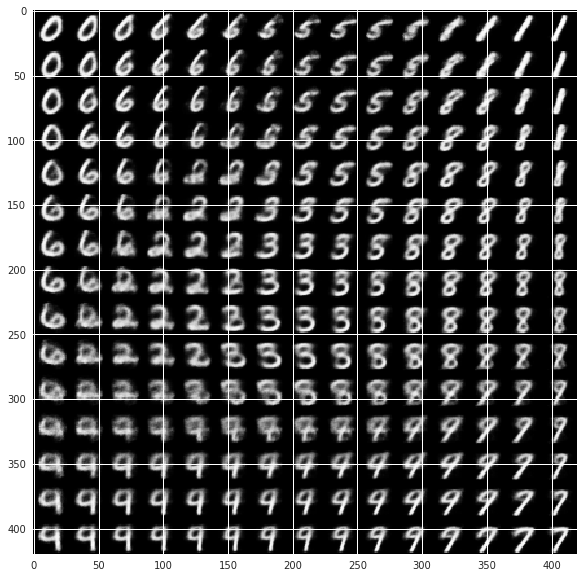

In [58]:
# sampling a grid of points from the 2D
# latent space and decoding them to images

# you'll display a grid of 15x15
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# transforms linearly spaced corrdinates using the SciPy
# ppf function to produce values of the latent variable
# z (because the prior of the latent space is Gaussian)
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size,
               j * digit_size : (j + 1) * digit_size] = digit
        
    
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')

# 8.4.4 Wrapping up

- Image generation with deep learning is done by
  learning latent spaces that capture statistical
  information about a dataset of images.  By sampling
  and decoding points from the latent space, you
  can generate never before seen images.
  - There are two major tools to do this: VAEs and GANs
- VAEs result in highly structured, continuous latent
  representations.  For this reason they work well for
  doing all sorts of image editing in latent space.
- GANs enable the generate of realistic single-frame
  images but may not induce latent spaces with solid
  structure and high continuity.

## 8.5 Introduction to generative adversarial networks

- *Generator network* - takes as input a random
  vector and decodes it into a synthetic image.
- *Discriminator network (or advesary* - takes as
  input an image (real or synthetic) and predicts
  whether the image came from the training set or was
  created by the generator network.
  
### 8.5.1 A schematic GAN implementation

### 8.5.2 A bag of tricks

### 8.5.3 The generator

In [60]:
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# transforms the input into a 16 x 12 128 channel
# feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# upsamples to 32 x 32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# produces a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)

# instantiates the generator model, which maps the
# input of shape (latent_dim) into an image of
# shape (32, 32, 3)
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

### 8.5.4 The discriminator

In [61]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# one dropout layer: an important trick!
x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

In [62]:
# uses gradient clipping (by value) in the optimizer
discriminator_optimizer = keras.optimizers.RMSprop(
   lr=0.0008,
   clipvalue=1.0,
   decay=1e-8) # to stapilize training, use lr decay

discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')